# Loading tokenized dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

data_dir = "/content/drive/MyDrive/music-project-ml-tokenized"
print(os.listdir(data_dir))


['vocab.json', 'train_ids.npy', 'test_ids.npy', 'val_ids.npy']


In [ ]:
import numpy as np
import json
from pathlib import Path

data_dir = Path("/content/drive/MyDrive/music-project-ml-tokenized")

train_ids = np.load(data_dir / "train_ids.npy", mmap_mode="r")
val_ids   = np.load(data_dir / "val_ids.npy", mmap_mode="r")
test_ids  = np.load(data_dir / "test_ids.npy", mmap_mode="r")

with open(data_dir / "vocab.json", "r", encoding="utf-8") as f:
    vocab = json.load(f)

print("Train:", train_ids.shape, train_ids.dtype)
print("Val:", val_ids.shape, val_ids.dtype)
print("Test:", test_ids.shape, test_ids.dtype)
print("Vocab size:", len(vocab["stoi"]))


Train: (100000000,) int32
Val: (25000000,) int32
Test: (25000000,) int32
Vocab size: 100


In [ ]:
# defining the basic training config
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import json
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Paths (adjust if your folder name is different)
data_dir = Path("/content/drive/MyDrive/music-project-ml-tokenized")

# Load ids with memory mapping
train_ids = np.load(data_dir / "train_ids.npy", mmap_mode="r")
val_ids   = np.load(data_dir / "val_ids.npy", mmap_mode="r")

with open(data_dir / "vocab.json", "r", encoding="utf-8") as f:
    vocab = json.load(f)

vocab_size = len(vocab["stoi"])
print("Vocab size:", vocab_size)

# Sequence length (context window)
block_size = 256  
batch_size = 64   


Device: cuda
Vocab size: 100


In [ ]:
class TokenDataset(Dataset):
    def __init__(self, ids_array, block_size: int):
        self.ids = ids_array
        self.block_size = block_size

    def __len__(self):
        return self.ids.shape[0] - self.block_size

    def __getitem__(self, idx):
        chunk = self.ids[idx : idx + self.block_size + 1]
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:],  dtype=torch.long)
        return x, y

train_dataset = TokenDataset(train_ids, block_size)
val_dataset   = TokenDataset(val_ids, block_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, drop_last=True)

xb, yb = next(iter(train_loader))
print("Batch shapes:", xb.shape, yb.shape)


Batch shapes: torch.Size([64, 256]) torch.Size([64, 256])


In [ ]:
# helper for validation loss
from torch.nn import functional as F

@torch.no_grad()
def evaluate_loss(model, loader, max_batches=200):
    model.eval()
    losses = []
    for i, (xb, yb) in enumerate(loader):
        if i >= max_batches:
            break
        xb = xb.to(device)
        yb = yb.to(device)
        _, loss = model(xb, yb)
        losses.append(loss.item())
    model.train()
    return sum(losses) / len(losses)


In [ ]:
def save_model_result(res, results_dir):
    name = res["name"]

    # 1) Save a lightweight JSON summary for tables / scaling plot
    summary = {
        "name": name,
        "n_params": res["n_params"],
        "val_loss": res["val_loss"],
        "epoch_time_sec": res["epoch_time_sec"],
        "max_memory_gb": res["max_memory_gb"],
        "config": res["config"],
    }
    with open(results_dir / f"{name}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)

    # 2) Save training loss curve as .npy (numpy array)
    np.save(results_dir / f"{name}_train_losses.npy",
            np.array(res["train_losses"], dtype=np.float32))

    print(f"Saved summary and train_losses for {name}.")


In [ ]:
from pathlib import Path
import json
import numpy as np

results_dir = Path("/content/drive/MyDrive/music-project-ml-results")
results_dir.mkdir(parents=True, exist_ok=True)
print("Saving results under:", results_dir)


Saving results under: /content/drive/MyDrive/music-project-ml-results


# Part 2: Transformer Scaling Study

In [ ]:
import torch
import torch.nn as nn
import math

class GPTConfig:
    def __init__(self,
                 vocab_size: int,
                 block_size: int,
                 n_layer: int,
                 n_head: int,
                 n_embd: int,
                 dropout: float = 0.1):
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd
        self.dropout = dropout


class CausalSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.head_dim = config.n_embd // config.n_head

        self.qkv = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_drop = nn.Dropout(config.dropout)
        self.resid_drop = nn.Dropout(config.dropout)

        self.register_buffer(
            "mask",
            torch.tril(torch.ones(config.block_size, config.block_size))
            .view(1, 1, config.block_size, config.block_size)
        )

    def forward(self, x):
        B, T, C = x.size()

        qkv = self.qkv(x)  # (B, T, 3*C)
        q, k, v = qkv.split(C, dim=2)

        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)  # (B, nh, T, T)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float("-inf"))
        att = torch.softmax(att, dim=-1)
        att = self.attn_drop(att)

        y = att @ v  # (B, nh, T, hd)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.resid_drop(self.proj(y))
        return y


class MLP(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.fc1 = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.fc2 = nn.Linear(4 * config.n_embd, config.n_embd)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


class GPTModel(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.token_embed = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_embed   = nn.Embedding(config.block_size, config.n_embd)
        self.drop = nn.Dropout(config.dropout)

        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.size()
        assert T <= self.config.block_size

        pos = torch.arange(0, T, dtype=torch.long, device=idx.device).unsqueeze(0)
        tok_emb = self.token_embed(idx)        # (B, T, C)
        pos_emb = self.pos_embed(pos)          # (1, T, C)
        x = self.drop(tok_emb + pos_emb)

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, vocab_size)

        loss = None
        if targets is not None:
            B, T, V = logits.shape
            logits_flat = logits.view(B*T, V)
            targets_flat = targets.view(B*T)
            loss = nn.functional.cross_entropy(logits_flat, targets_flat)

        return logits, loss


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
config_tiny = GPTConfig(
    vocab_size=vocab_size,
    block_size=block_size,
    n_layer=2,
    n_head=4,
    n_embd=192,
    dropout=0.1,
)

model_tiny = GPTModel(config_tiny).to(device)
n_params_tiny = count_parameters(model_tiny)
print("Tiny model parameters:", n_params_tiny)

xb, yb = next(iter(train_loader))
xb = xb.to(device)
yb = yb.to(device)

with torch.no_grad():
    logits, loss = model_tiny(xb, yb)

print("Logits shape:", logits.shape)
print("Loss:", loss.item())


Tiny model parameters: 977664
Logits shape: torch.Size([64, 256, 100])
Loss: 4.594717502593994


In [ ]:
# Define model size configs in Colab
import math, time
model_sizes = {
    # already trained with this config
    "tiny":   dict(n_layer=2,  n_head=4, n_embd=192),   # ~0.97M

    # ≈ 4.8M params  → “Small ≈ 5M”
    "small":  dict(n_layer=6,  n_head=4, n_embd=256),   # ~4.8M

    # ≈ 21M params   → “Medium ≈ 20M”
    "medium": dict(n_layer=12, n_head=8, n_embd=384),   # ~21M

    # ≈ 51M params   → “Large ≈ 50M”
    "large":  dict(n_layer=16, n_head=8, n_embd=512),   # ~50.6M

    # ≈ 99M params   → “XL ≈ 100M (or largest feasible)”
    "xl":     dict(n_layer=20, n_head=8, n_embd=640),   # ~98.6M
}

def print_param_counts():
    for name, cfg in model_sizes.items():
        config = GPTConfig(
            vocab_size=vocab_size,
            block_size=block_size,
            n_layer=cfg["n_layer"],
            n_head=cfg["n_head"],
            n_embd=cfg["n_embd"],
            dropout=0.1,
        )
        model = GPTModel(config).to(device)
        n_params = count_parameters(model)
        print(f"{name}: {n_params:,} parameters")
        del model
        torch.cuda.empty_cache()

print_param_counts()


tiny: 977,664 parameters
small: 4,855,808 parameters
medium: 21,469,440 parameters
large: 50,672,640 parameters
xl: 98,763,520 parameters


In [ ]:
# Training loop for “1 epoch ≈ 100M tokens”
tokens_per_step = batch_size * block_size
target_tokens_per_epoch = 100_000_000
steps_per_epoch = target_tokens_per_epoch // tokens_per_step
print("Tokens per step:", tokens_per_step)
print("Steps per epoch:", steps_per_epoch)

def train_one_model(name, cfg, steps=steps_per_epoch, lr=3e-4):
    print(f"\n=== Training {name} ===")
    print(cfg)

    config = GPTConfig(
        vocab_size=vocab_size,
        block_size=block_size,
        n_layer=cfg["n_layer"],
        n_head=cfg["n_head"],
        n_embd=cfg["n_embd"],
        dropout=0.1,
    )
    model = GPTModel(config).to(device)
    n_params = count_parameters(model)
    print(f"{name} params: {n_params:,}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)

    warmup_steps = max(10, int(0.05 * steps))  # 5% warmup

    def get_lr(step):
        if step < warmup_steps:
            return lr * step / warmup_steps
        # cosine decay after warmup
        progress = (step - warmup_steps) / max(1, (steps - warmup_steps))
        return lr * 0.5 * (1.0 + math.cos(math.pi * progress))

    train_losses = []

    # reset GPU memory stats so we can measure peak usage for this model
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    start_time = time.time()
    train_iter = iter(train_loader)

    for step in range(1, steps + 1):
        try:
            xb, yb = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            xb, yb = next(train_iter)

        xb = xb.to(device)
        yb = yb.to(device)

        lr_step = get_lr(step)
        for g in optimizer.param_groups:
            g["lr"] = lr_step

        optimizer.zero_grad(set_to_none=True)
        logits, loss = model(xb, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_losses.append(loss.item())

        if step % 200 == 0 or step == 1:
            print(f"step {step}/{steps} - loss {loss.item():.4f} - lr {lr_step:.2e}")

    epoch_time = time.time() - start_time
    val_loss = evaluate_loss(model, val_loader, max_batches=200)

    max_mem_gb = None
    if torch.cuda.is_available():
        peak_bytes = torch.cuda.max_memory_allocated()
        max_mem_gb = peak_bytes / 1e9  # convert to GB
        print(f"Peak GPU memory: {max_mem_gb:.2f} GB")

    print(f"{name} done. val_loss={val_loss:.4f}, time={epoch_time/60:.1f} min")

    return {
        "name": name,
        "config": cfg,
        "n_params": n_params,
        "train_losses": train_losses,
        "val_loss": val_loss,
        "epoch_time_sec": epoch_time,
        "max_memory_gb": max_mem_gb,
    }



Tokens per step: 16384
Steps per epoch: 6103


In [ ]:
results = []

res_tiny = train_one_model("tiny", model_sizes["tiny"])
results.append(res_tiny)



=== Training tiny ===
{'n_layer': 2, 'n_head': 4, 'n_embd': 192}
tiny params: 977,664
step 1/6103 - loss 4.7200 - lr 9.84e-07
step 200/6103 - loss 1.6505 - lr 1.97e-04
step 400/6103 - loss 1.2557 - lr 3.00e-04
step 600/6103 - loss 1.2400 - lr 2.98e-04
step 800/6103 - loss 1.1956 - lr 2.95e-04
step 1000/6103 - loss 1.1458 - lr 2.89e-04
step 1200/6103 - loss 1.0578 - lr 2.83e-04
step 1400/6103 - loss 0.9649 - lr 2.74e-04
step 1600/6103 - loss 0.9204 - lr 2.65e-04
step 1800/6103 - loss 0.8487 - lr 2.53e-04
step 2000/6103 - loss 0.9078 - lr 2.41e-04
step 2200/6103 - loss 0.8185 - lr 2.28e-04
step 2400/6103 - loss 0.9651 - lr 2.13e-04
step 2600/6103 - loss 0.7877 - lr 1.98e-04
step 2800/6103 - loss 0.8049 - lr 1.83e-04
step 3000/6103 - loss 0.8584 - lr 1.67e-04
step 3200/6103 - loss 0.8110 - lr 1.50e-04
step 3400/6103 - loss 0.7499 - lr 1.34e-04
step 3600/6103 - loss 0.8192 - lr 1.18e-04
step 3800/6103 - loss 0.7651 - lr 1.02e-04
step 4000/6103 - loss 0.8134 - lr 8.73e-05
step 4200/6103 - 

In [ ]:
results = []  # start fresh for all models in this session
results.append(res_tiny)

for r in results:
    print(
        r["name"],
        "| params:", f"{r['n_params']:,}",
        "| val_loss:", f"{r['val_loss']:.4f}",
        "| time(min):", f"{r['epoch_time_sec']/60:.2f}",
        "| peak_mem(GB):", f"{r['max_memory_gb']:.2f}" if r["max_memory_gb"] is not None else "n/a",
    )


tiny | params: 977,664 | val_loss: 0.7236 | time(min): 6.23 | peak_mem(GB): 0.89


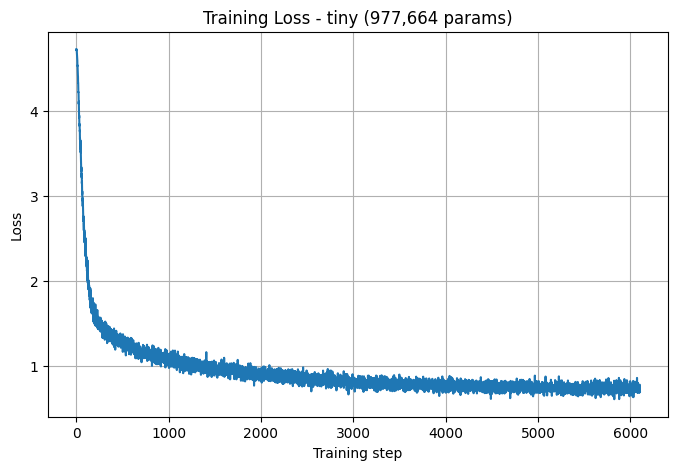

In [ ]:
import matplotlib.pyplot as plt

def plot_train_curve(res):
    losses = res["train_losses"]
    steps = range(1, len(losses) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(steps, losses)
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.title(f"Training Loss - {res['name']} ({res['n_params']:,} params)")
    plt.grid(True)
    plt.show()

plot_train_curve(res_tiny)


In [ ]:
res_small = train_one_model("small", model_sizes["small"])
save_model_result(res_small, results_dir)


=== Training small ===
{'n_layer': 6, 'n_head': 4, 'n_embd': 256}
small params: 4,855,808
step 1/6103 - loss 4.6888 - lr 9.84e-07
step 200/6103 - loss 1.4561 - lr 1.97e-04
step 400/6103 - loss 1.2010 - lr 3.00e-04
step 600/6103 - loss 1.0516 - lr 2.98e-04
step 800/6103 - loss 0.9732 - lr 2.95e-04
step 1000/6103 - loss 0.9425 - lr 2.89e-04
step 1200/6103 - loss 0.6967 - lr 2.83e-04
step 1400/6103 - loss 0.7199 - lr 2.74e-04
step 1600/6103 - loss 0.6983 - lr 2.65e-04
step 1800/6103 - loss 0.7383 - lr 2.53e-04
step 2000/6103 - loss 0.6723 - lr 2.41e-04
step 2200/6103 - loss 0.6071 - lr 2.28e-04
step 2400/6103 - loss 0.6119 - lr 2.13e-04
step 2600/6103 - loss 0.6642 - lr 1.98e-04
step 2800/6103 - loss 0.6278 - lr 1.83e-04
step 3000/6103 - loss 0.6628 - lr 1.67e-04
step 3200/6103 - loss 0.5937 - lr 1.50e-04
step 3400/6103 - loss 0.5864 - lr 1.34e-04
step 3600/6103 - loss 0.6413 - lr 1.18e-04
step 3800/6103 - loss 0.5895 - lr 1.02e-04
step 4000/6103 - loss 0.6338 - lr 8.73e-05
step 4200/610

In [ ]:
results.append(res_small)

for r in results:
    print(
        r["name"],
        "| params:", f"{r['n_params']:,}",
        "| val_loss:", f"{r['val_loss']:.4f}",
        "| time(min):", f"{r['epoch_time_sec']/60:.2f}",
        "| peak_mem(GB):", f"{r['max_memory_gb']:.2f}" if r["max_memory_gb"] is not None else "n/a",
    )

tiny | params: 977,664 | val_loss: 0.7236 | time(min): 6.23 | peak_mem(GB): 0.89
small | params: 4,855,808 | val_loss: 0.5291 | time(min): 23.30 | peak_mem(GB): 2.81


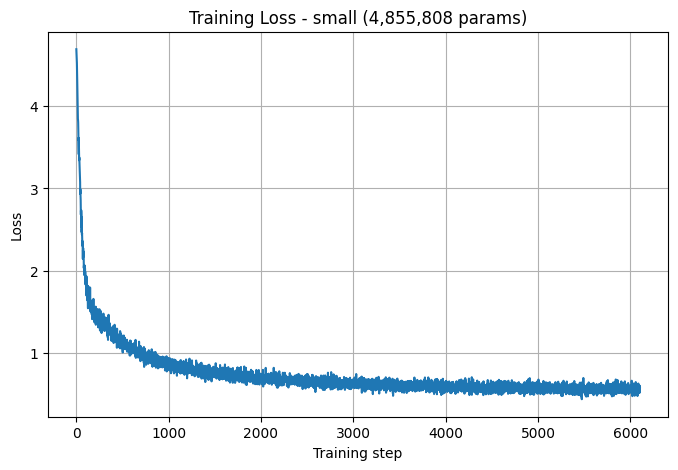

In [ ]:
import matplotlib.pyplot as plt

def plot_train_curve(res):
    losses = res["train_losses"]
    steps = range(1, len(losses) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(steps, losses)
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.title(f"Training Loss - {res['name']} ({res['n_params']:,} params)")
    plt.grid(True)
    plt.show()

plot_train_curve(res_small)


In [ ]:
res_medium = train_one_model("medium", model_sizes["medium"])
save_model_result(res_medium, results_dir)


=== Training medium ===
{'n_layer': 12, 'n_head': 8, 'n_embd': 384}
medium params: 21,469,440
step 1/6103 - loss 4.6898 - lr 9.84e-07
step 200/6103 - loss 1.4915 - lr 1.97e-04
step 400/6103 - loss 1.1339 - lr 3.00e-04
step 600/6103 - loss 0.9208 - lr 2.98e-04
step 800/6103 - loss 0.8035 - lr 2.95e-04
step 1000/6103 - loss 0.7556 - lr 2.89e-04
step 1200/6103 - loss 0.7394 - lr 2.83e-04
step 1400/6103 - loss 0.6717 - lr 2.74e-04
step 1600/6103 - loss 0.6478 - lr 2.65e-04
step 1800/6103 - loss 0.5780 - lr 2.53e-04
step 2000/6103 - loss 0.5785 - lr 2.41e-04
step 2200/6103 - loss 0.6287 - lr 2.28e-04
step 2400/6103 - loss 0.5915 - lr 2.13e-04
step 2600/6103 - loss 0.5965 - lr 1.98e-04
step 2800/6103 - loss 0.5628 - lr 1.83e-04
step 3000/6103 - loss 0.5734 - lr 1.67e-04
step 3200/6103 - loss 0.4958 - lr 1.50e-04
step 3400/6103 - loss 0.5374 - lr 1.34e-04
step 3600/6103 - loss 0.5414 - lr 1.18e-04
step 3800/6103 - loss 0.5062 - lr 1.02e-04
step 4000/6103 - loss 0.4855 - lr 8.73e-05
step 4200

In [ ]:
results.append(res_medium)

for r in results:
    print(
        r["name"],
        "| params:", f"{r['n_params']:,}",
        "| val_loss:", f"{r['val_loss']:.4f}",
        "| time(min):", f"{r['epoch_time_sec']/60:.2f}",
        "| peak_mem(GB):", f"{r['max_memory_gb']:.2f}" if r["max_memory_gb"] is not None else "n/a",
    )

tiny | params: 977,664 | val_loss: 0.7236 | time(min): 6.23 | peak_mem(GB): 0.89
small | params: 4,855,808 | val_loss: 0.5291 | time(min): 23.30 | peak_mem(GB): 2.81
medium | params: 21,469,440 | val_loss: 0.4735 | time(min): 93.66 | peak_mem(GB): 9.11


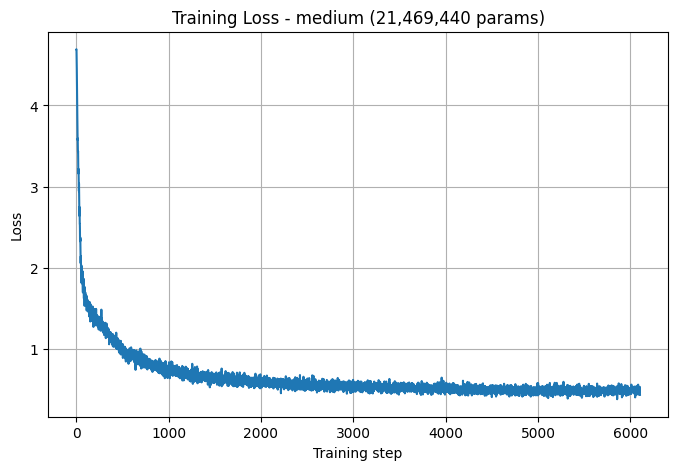

In [ ]:
import matplotlib.pyplot as plt

def plot_train_curve(res):
    losses = res["train_losses"]
    steps = range(1, len(losses) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(steps, losses)
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.title(f"Training Loss - {res['name']} ({res['n_params']:,} params)")
    plt.grid(True)
    plt.show()

plot_train_curve(res_medium)


In [ ]:
def save_model_result(res, results_dir):
    name = res["name"]

    summary = {
        "name": name,
        "n_params": res["n_params"],
        "val_loss": res["val_loss"],
        "epoch_time_sec": res["epoch_time_sec"],
        "max_memory_gb": res["max_memory_gb"],
        "config": res["config"],
    }
    with open(results_dir / f"{name}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)

    # Save training loss curve as .npy (numpy array)
    np.save(results_dir / f"{name}_train_losses.npy",
            np.array(res["train_losses"], dtype=np.float32))

    print(f"Saved summary and train_losses for {name}.")

In [ ]:
res_large = train_one_model("large", model_sizes["large"])
save_model_result(res_large, results_dir)

In [ ]:
save_model_result(res_large, results_dir)

Saved summary and train_losses for large.


In [ ]:
res_xl = train_one_model("xl", model_sizes["xl"])
save_model_result(res_xl, results_dir)


=== Training xl ===
{'n_layer': 20, 'n_head': 8, 'n_embd': 640}
xl params: 98,763,520
step 1/6103 - loss 4.8551 - lr 9.84e-07
step 200/6103 - loss 1.2795 - lr 1.97e-04
step 400/6103 - loss 0.8981 - lr 3.00e-04
step 600/6103 - loss 0.7303 - lr 2.98e-04
step 800/6103 - loss 0.7311 - lr 2.95e-04
step 1000/6103 - loss 0.6273 - lr 2.89e-04
step 1200/6103 - loss 0.5825 - lr 2.83e-04
step 1400/6103 - loss 0.5472 - lr 2.74e-04
step 1600/6103 - loss 0.6123 - lr 2.65e-04
step 1800/6103 - loss 0.5498 - lr 2.53e-04
step 2000/6103 - loss 0.5236 - lr 2.41e-04
step 2200/6103 - loss 0.4678 - lr 2.28e-04
step 2400/6103 - loss 0.4990 - lr 2.13e-04
step 2600/6103 - loss 0.4564 - lr 1.98e-04
step 2800/6103 - loss 0.4897 - lr 1.83e-04
step 3000/6103 - loss 0.4351 - lr 1.67e-04
step 3200/6103 - loss 0.5029 - lr 1.50e-04
step 3400/6103 - loss 0.5334 - lr 1.34e-04
step 3600/6103 - loss 0.4453 - lr 1.18e-04
step 3800/6103 - loss 0.4634 - lr 1.02e-04
step 4000/6103 - loss 0.4532 - lr 8.73e-05
step 4200/6103 - 

In [ ]:
import json
import numpy as np
from pathlib import Path

results_dir = Path("/content/drive/MyDrive/music-project-ml-results")
model_names = ["tiny", "small", "medium", "large", "xl"]

results = []
for name in model_names:
    with open(results_dir / f"{name}_summary.json", "r") as f:
        summary = json.load(f)
    train_losses = np.load(results_dir / f"{name}_train_losses.npy")
    summary["train_losses"] = train_losses.tolist()
    results.append(summary)

print("Loaded:", [r["name"] for r in results])


Loaded: ['tiny', 'small', 'medium', 'large', 'xl']


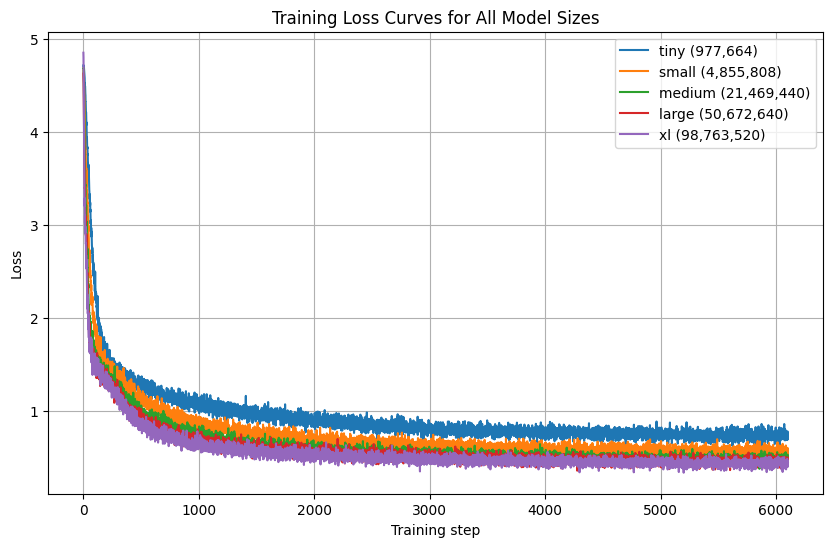

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for r in results:
    losses = r["train_losses"]
    steps = range(1, len(losses) + 1)
    plt.plot(steps, losses, label=f"{r['name']} ({r['n_params']:,})")

plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training Loss Curves for All Model Sizes")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = np.array([r["n_params"] for r in results], dtype=np.float64)
L = np.array([r["val_loss"]  for r in results], dtype=np.float64)

print("Params:", N)
print("Val losses:", L)


Params: [  977664.  4855808. 21469440. 50672640. 98763520.]
Val losses: [0.72358209 0.52913012 0.47350465 0.45434562 0.4418685 ]


In [ ]:
from scipy.optimize import curve_fit

def power_law(N, a, alpha, c):
    return a * N**(-alpha) + c

# Initial guesses: a ~ 1.0, alpha ~ 0.1, c ~ min(L)
p0 = [1.0, 0.1, float(L.min() - 0.05)]
popt, pcov = curve_fit(power_law, N, L, p0=p0, maxfev=10000)

a_fit, alpha_fit, c_fit = popt
print(f"Fitted power law: L = a * N^(-alpha) + c")
print(f"a = {a_fit:.4g}, alpha = {alpha_fit:.4f}, c = {c_fit:.4f}")


Fitted power law: L = a * N^(-alpha) + c
a = 3063, alpha = 0.6715, c = 0.4325


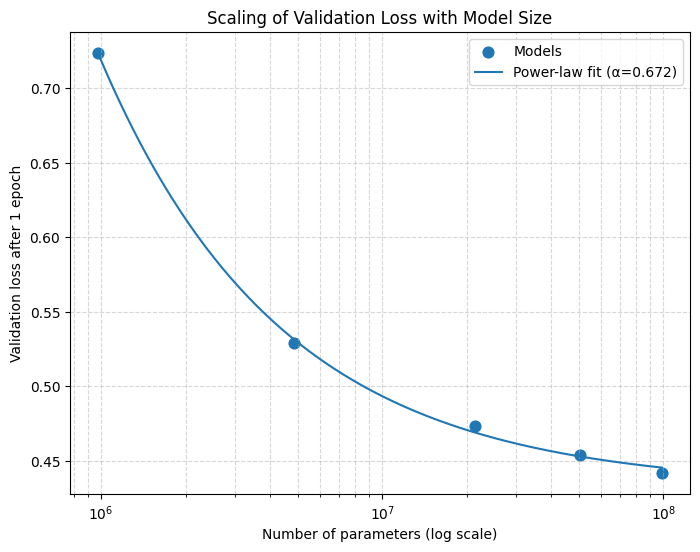

In [ ]:
# Smooth curve over the parameter range
N_fit = np.logspace(np.log10(N.min()), np.log10(N.max()), 200)
L_fit = power_law(N_fit, a_fit, alpha_fit, c_fit)

plt.figure(figsize=(8, 6))
plt.scatter(N, L, label="Models", s=60)
plt.plot(N_fit, L_fit, label=f"Power-law fit (α={alpha_fit:.3f})")

plt.xscale("log")
plt.xlabel("Number of parameters (log scale)")
plt.ylabel("Validation loss after 1 epoch")
plt.title("Scaling of Validation Loss with Model Size")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


In [ ]:
print(f"{'name':<8} {'layers':>6} {'heads':>6} {'d_model':>8} {'params':>12} {'val_loss':>10} {'time(min)':>10} {'GPU(GB)':>8}")
print("-"*72)
for r in results:
    cfg = r["config"]
    print(
        f"{r['name']:<8} "
        f"{cfg['n_layer']:>6} "
        f"{cfg['n_head']:>6} "
        f"{cfg['n_embd']:>8} "
        f"{r['n_params']:>12,} "
        f"{r['val_loss']:>10.4f} "
        f"{r['epoch_time_sec']/60:>10.2f} "
        f"{(r['max_memory_gb'] or 0):>8.2f}"
    )


name     layers  heads  d_model       params   val_loss  time(min)  GPU(GB)
------------------------------------------------------------------------
tiny          2      4      192      977,664     0.7236       6.23     0.89
small         6      4      256    4,855,808     0.5291      23.30     2.81
medium       12      8      384   21,469,440     0.4735      93.66     9.11
large        16      8      512   50,672,640     0.4543      41.19    14.61
xl           20      8      640   98,763,520     0.4419      71.48    21.47


# Part 3: RNN Scaling Study

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# We'll reuse vocab_size, block_size, device, count_parameters, train_loader, val_loader from before.

class LSTMLM(nn.Module):
    def __init__(self, vocab_size, d_model=512, n_layer=2, block_size=256, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layer = n_layer
        self.block_size = block_size

        # Token embeddings
        self.token_emb = nn.Embedding(vocab_size, d_model)

        # LSTM stack
        self.lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=d_model,
            num_layers=n_layer,
            batch_first=True,
            dropout=dropout if n_layer > 1 else 0.0,
        )

        # Optional LayerNorm on top
        self.ln_f = nn.LayerNorm(d_model)

        # Output projection to vocab
        self.head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, idx, targets=None):
        # idx: (B, T)
        x = self.token_emb(idx)          # (B, T, d_model)
        out, _ = self.lstm(x)            # (B, T, d_model)
        out = self.ln_f(out)             # (B, T, d_model)
        logits = self.head(out)          # (B, T, vocab_size)

        loss = None
        if targets is not None:
            # Flatten for cross-entropy
            B, T, C = logits.shape
            loss = F.cross_entropy(
                logits.view(B * T, C),
                targets.view(B * T),
            )
        return logits, loss

# Choose 4 RNN sizes roughly matching your transformer sizes
rnn_sizes = {
    # ≈ 1M parameters
    "rnn_tiny":   dict(n_layer=2, d_model=256),

    # ≈ 5M parameters
    "rnn_small":  dict(n_layer=2, d_model=512),

    # ≈ 20M parameters (same as your previous "rnn_large" ≈ 19M)
    "rnn_medium": dict(n_layer=4, d_model=768),

    # ≈ 40–60M parameters (largest RNN you can realistically train)
    "rnn_large":  dict(n_layer=4, d_model=1024),

    "rnn_xl":     dict(n_layer=8, d_model=1280),
}


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_rnn_param_counts():
    for name, cfg in rnn_sizes.items():
        model = LSTMLM(
            vocab_size=vocab_size,
            d_model=cfg["d_model"],
            n_layer=cfg["n_layer"],
            block_size=block_size,
        )
        n_params = count_parameters(model)
        print(
            f"{name}: layers={cfg['n_layer']}, d_model={cfg['d_model']}, "
            f"params={n_params:,}"
        )

print_rnn_param_counts()


rnn_tiny: layers=2, d_model=256, params=1,104,384
rnn_small: layers=2, d_model=512, params=4,305,920
rnn_medium: layers=4, d_model=768, params=19,054,080
rnn_large: layers=4, d_model=1024, params=33,794,048
rnn_xl: layers=8, d_model=1280, params=105,198,080


In [ ]:
# Recompute epoch size (same as transformers)
batch_size = 64
block_size = 256
tokens_per_step = batch_size * block_size  # 16384 tokens per step

train_tokens = 100_000_000  # same 100M train tokens as before

steps_per_epoch = train_tokens // tokens_per_step
steps_per_epoch


6103

In [ ]:
import math, time
def train_one_rnn(name, cfg, steps=steps_per_epoch, lr=3e-4):
    print(f"\n=== Training {name} ===")
    print(cfg)

    model = LSTMLM(
        vocab_size=vocab_size,
        d_model=cfg["d_model"],
        n_layer=cfg["n_layer"],
        block_size=block_size,
        dropout=0.1,
    ).to(device)

    n_params = count_parameters(model)
    print(f"{name} params: {n_params:,}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)

    warmup_steps = max(10, int(0.05 * steps))

    def get_lr(step):
        if step < warmup_steps:
            return lr * step / warmup_steps
        progress = (step - warmup_steps) / max(1, (steps - warmup_steps))
        return lr * 0.5 * (1.0 + math.cos(math.pi * progress))

    train_losses = []

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    start_time = time.time()
    train_iter = iter(train_loader)

    for step in range(1, steps + 1):
        try:
            xb, yb = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            xb, yb = next(train_iter)

        xb = xb.to(device)
        yb = yb.to(device)

        lr_step = get_lr(step)
        for g in optimizer.param_groups:
            g["lr"] = lr_step

        optimizer.zero_grad(set_to_none=True)
        logits, loss = model(xb, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_losses.append(loss.item())

        if step % 200 == 0 or step == 1:
            print(f"step {step}/{steps} - loss {loss.item():.4f} - lr {lr_step:.2e}")

    epoch_time = time.time() - start_time
    val_loss = evaluate_loss(model, val_loader, max_batches=200)

    max_mem_gb = None
    if torch.cuda.is_available():
        peak_bytes = torch.cuda.max_memory_allocated()
        max_mem_gb = peak_bytes / 1e9
        print(f"Peak GPU memory: {max_mem_gb:.2f} GB")

    print(f"{name} done. val_loss={val_loss:.4f}, time={epoch_time/60:.1f} min")

    return {
        "name": name,
        "config": cfg,
        "n_params": n_params,
        "train_losses": train_losses,
        "val_loss": val_loss,
        "epoch_time_sec": epoch_time,
        "max_memory_gb": max_mem_gb,
    }


In [ ]:
def save_model_result(res, results_dir):
    name = res["name"]

    # 1) Save a lightweight JSON summary for tables / scaling plot
    summary = {
        "name": name,
        "n_params": res["n_params"],
        "val_loss": res["val_loss"],
        "epoch_time_sec": res["epoch_time_sec"],
        "max_memory_gb": res["max_memory_gb"],
        "config": res["config"],
    }
    with open(results_dir / f"{name}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)

    # 2) Save training loss curve as .npy (numpy array)
    np.save(results_dir / f"{name}_train_losses.npy",
            np.array(res["train_losses"], dtype=np.float32))

    print(f"Saved summary and train_losses for {name}.")

In [ ]:
rnn_results = []

res_rnn_tiny = train_one_rnn("rnn_tiny", rnn_sizes["rnn_tiny"])
save_model_result(res_rnn_tiny, results_dir)

In [ ]:
save_model_result(res_rnn_tiny, results_dir)

Saved summary and train_losses for rnn_tiny.


In [ ]:
rnn_results = [res_rnn_tiny]

for r in rnn_results:
    print(
        r["name"],
        "| params:", f"{r['n_params']:,}",
        "| val_loss:", f"{r['val_loss']:.4f}",
        "| time(min):", f"{r['epoch_time_sec']/60:.2f}",
        "| peak_mem(GB):", f"{r['max_memory_gb']:.2f}" if r["max_memory_gb"] else "n/a",
    )


rnn_tiny | params: 1,104,384 | val_loss: 0.7080 | time(min): 2.01 | peak_mem(GB): 0.48


In [ ]:
res_rnn_small = train_one_rnn("rnn_small", rnn_sizes["rnn_small"])
save_model_result(res_rnn_small, results_dir)
rnn_results.append(res_rnn_small)


=== Training rnn_small ===
{'n_layer': 2, 'd_model': 512}
rnn_small params: 4,305,920
step 1/6103 - loss 4.7878 - lr 9.84e-07
step 200/6103 - loss 1.1599 - lr 1.97e-04
step 400/6103 - loss 1.0461 - lr 3.00e-04
step 600/6103 - loss 0.9324 - lr 2.98e-04
step 800/6103 - loss 0.7185 - lr 2.95e-04
step 1000/6103 - loss 0.6655 - lr 2.89e-04
step 1200/6103 - loss 0.6349 - lr 2.83e-04
step 1400/6103 - loss 0.7260 - lr 2.74e-04
step 1600/6103 - loss 0.6523 - lr 2.65e-04
step 1800/6103 - loss 0.5934 - lr 2.53e-04
step 2000/6103 - loss 0.7093 - lr 2.41e-04
step 2200/6103 - loss 0.6470 - lr 2.28e-04
step 2400/6103 - loss 0.6409 - lr 2.13e-04
step 2600/6103 - loss 0.6244 - lr 1.98e-04
step 2800/6103 - loss 0.6521 - lr 1.83e-04
step 3000/6103 - loss 0.6191 - lr 1.67e-04
step 3200/6103 - loss 0.5088 - lr 1.50e-04
step 3400/6103 - loss 0.5677 - lr 1.34e-04
step 3600/6103 - loss 0.6280 - lr 1.18e-04
step 3800/6103 - loss 0.6060 - lr 1.02e-04
step 4000/6103 - loss 0.5921 - lr 8.73e-05
step 4200/6103 - 

In [ ]:
for r in rnn_results:
    print(
        r["name"],
        "| params:", f"{r['n_params']:,}",
        "| val_loss:", f"{r['val_loss']:.4f}",
        "| time(min):", f"{r['epoch_time_sec']/60:.2f}",
        "| peak_mem(GB):", f"{r['max_memory_gb']:.2f}" if r["max_memory_gb"] else "n/a",
    )


rnn_tiny | params: 1,104,384 | val_loss: 0.7080 | time(min): 2.01 | peak_mem(GB): 0.48
rnn_small | params: 4,305,920 | val_loss: 0.6151 | time(min): 2.37 | peak_mem(GB): 0.94


In [ ]:
res_rnn_medium = train_one_rnn("rnn_medium", rnn_sizes["rnn_medium"])
save_model_result(res_rnn_medium, results_dir)
rnn_results.append(res_rnn_medium)

for r in rnn_results:
    print(
        r["name"],
        "| params:", f"{r['n_params']:,}",
        "| val_loss:", f"{r['val_loss']:.4f}",
        "| time(min):", f"{r['epoch_time_sec']/60:.2f}",
        "| peak_mem(GB):", f"{r['max_memory_gb']:.2f}" if r["max_memory_gb"] else "n/a",
    )


=== Training rnn_medium ===
{'n_layer': 4, 'd_model': 768}
rnn_medium params: 19,054,080
step 1/6103 - loss 4.7296 - lr 9.84e-07
step 200/6103 - loss 1.1691 - lr 1.97e-04
step 400/6103 - loss 0.9028 - lr 3.00e-04
step 600/6103 - loss 0.7366 - lr 2.98e-04
step 800/6103 - loss 0.7056 - lr 2.95e-04
step 1000/6103 - loss 0.6939 - lr 2.89e-04
step 1200/6103 - loss 0.7496 - lr 2.83e-04
step 1400/6103 - loss 0.6018 - lr 2.74e-04
step 1600/6103 - loss 0.6468 - lr 2.65e-04
step 1800/6103 - loss 0.6670 - lr 2.53e-04
step 2000/6103 - loss 0.6058 - lr 2.41e-04
step 2200/6103 - loss 0.6084 - lr 2.28e-04
step 2400/6103 - loss 0.5569 - lr 2.13e-04
step 2600/6103 - loss 0.6037 - lr 1.98e-04
step 2800/6103 - loss 0.5805 - lr 1.83e-04
step 3000/6103 - loss 0.5499 - lr 1.67e-04
step 3200/6103 - loss 0.5524 - lr 1.50e-04
step 3400/6103 - loss 0.5466 - lr 1.34e-04
step 3600/6103 - loss 0.5967 - lr 1.18e-04
step 3800/6103 - loss 0.5814 - lr 1.02e-04
step 4000/6103 - loss 0.5423 - lr 8.73e-05
step 4200/6103

In [ ]:
res_rnn_large = train_one_rnn("rnn_large", rnn_sizes["rnn_large"])
save_model_result(res_rnn_large, results_dir)
rnn_results.append(res_rnn_large)

for r in rnn_results:
    print(
        r["name"],
        "| params:", f"{r['n_params']:,}",
        "| val_loss:", f"{r['val_loss']:.4f}",
        "| time(min):", f"{r['epoch_time_sec']/60:.2f}",
        "| peak_mem(GB):", f"{r['max_memory_gb']:.2f}" if r["max_memory_gb"] else "n/a",
    )


=== Training rnn_large ===
{'n_layer': 4, 'd_model': 1024}
rnn_large params: 33,794,048
step 1/6103 - loss 4.9622 - lr 9.84e-07
step 200/6103 - loss 1.2319 - lr 1.97e-04
step 400/6103 - loss 0.8792 - lr 3.00e-04
step 600/6103 - loss 0.8360 - lr 2.98e-04
step 800/6103 - loss 0.6764 - lr 2.95e-04
step 1000/6103 - loss 0.6523 - lr 2.89e-04
step 1200/6103 - loss 0.7055 - lr 2.83e-04
step 1400/6103 - loss 0.6328 - lr 2.74e-04
step 1600/6103 - loss 0.5884 - lr 2.65e-04
step 1800/6103 - loss 0.5951 - lr 2.53e-04
step 2000/6103 - loss 0.5873 - lr 2.41e-04
step 2200/6103 - loss 0.5774 - lr 2.28e-04
step 2400/6103 - loss 0.5306 - lr 2.13e-04
step 2600/6103 - loss 0.5430 - lr 1.98e-04
step 2800/6103 - loss 0.5692 - lr 1.83e-04
step 3000/6103 - loss 0.4702 - lr 1.67e-04
step 3200/6103 - loss 0.5738 - lr 1.50e-04
step 3400/6103 - loss 0.4857 - lr 1.34e-04
step 3600/6103 - loss 0.5281 - lr 1.18e-04
step 3800/6103 - loss 0.4930 - lr 1.02e-04
step 4000/6103 - loss 0.4953 - lr 8.73e-05
step 4200/6103 

In [ ]:
res_rnn_xl = train_one_rnn("rnn_xl", rnn_sizes["rnn_xl"])
save_model_result(res_rnn_xl, results_dir)
rnn_results.append(res_rnn_xl)

for r in rnn_results:
    print(
        r["name"],
        "| params:", f"{r['n_params']:,}",
        "| val_loss:", f"{r['val_loss']:.4f}",
        "| time(min):", f"{r['epoch_time_sec']/60:.2f}",
        "| peak_mem(GB):", f"{r['max_memory_gb']:.2f}" if r["max_memory_gb"] else "n/a",
    )


=== Training rnn_xl ===
{'n_layer': 8, 'd_model': 1280}
rnn_xl params: 105,198,080
step 1/6103 - loss 4.6871 - lr 9.84e-07
step 200/6103 - loss 1.7951 - lr 1.97e-04
step 400/6103 - loss 0.9462 - lr 3.00e-04
step 600/6103 - loss 0.9342 - lr 2.98e-04
step 800/6103 - loss 0.7758 - lr 2.95e-04
step 1000/6103 - loss 0.6827 - lr 2.89e-04
step 1200/6103 - loss 0.7096 - lr 2.83e-04
step 1400/6103 - loss 0.6849 - lr 2.74e-04
step 1600/6103 - loss 0.6824 - lr 2.65e-04
step 1800/6103 - loss 0.6318 - lr 2.53e-04
step 2000/6103 - loss 0.5571 - lr 2.41e-04
step 2200/6103 - loss 0.6022 - lr 2.28e-04
step 2400/6103 - loss 0.5385 - lr 2.13e-04
step 2600/6103 - loss 0.6041 - lr 1.98e-04
step 2800/6103 - loss 0.5701 - lr 1.83e-04
step 3000/6103 - loss 0.6020 - lr 1.67e-04
step 3200/6103 - loss 0.5037 - lr 1.50e-04
step 3400/6103 - loss 0.5446 - lr 1.34e-04
step 3600/6103 - loss 0.4683 - lr 1.18e-04
step 3800/6103 - loss 0.5469 - lr 1.02e-04
step 4000/6103 - loss 0.5688 - lr 8.73e-05
step 4200/6103 - los

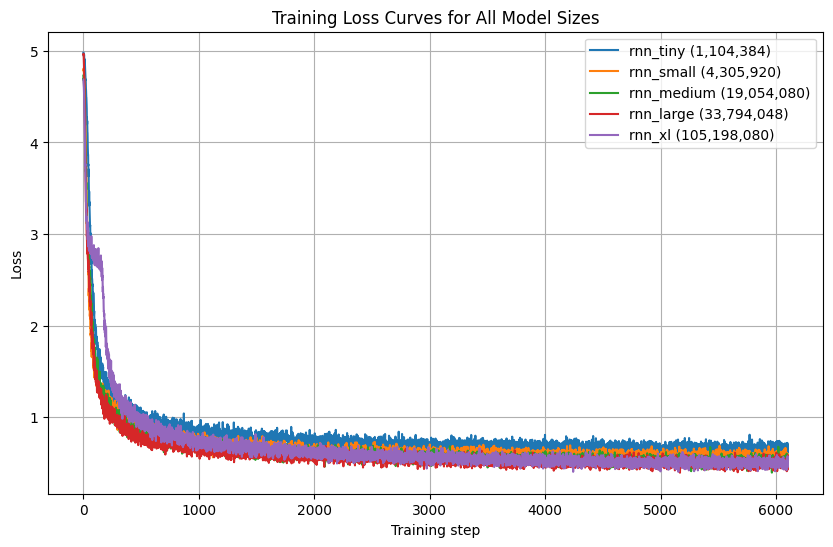

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for r in rnn_results:
    losses = r["train_losses"]
    steps = range(1, len(losses) + 1)
    plt.plot(steps, losses, label=f"{r['name']} ({r['n_params']:,})")

plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training Loss Curves for All Model Sizes")
plt.legend()
plt.grid(True)
plt.show()

RNN params: [1.1043840e+06 4.3059200e+06 1.9054080e+07 3.3794048e+07 1.0519808e+08]
RNN val losses: [0.70800424 0.61509892 0.56885684 0.54727321 0.55599071]
RNN power law: L = a * N^(-alpha) + c
a = 969.1, alpha = 0.6214, c = 0.5385


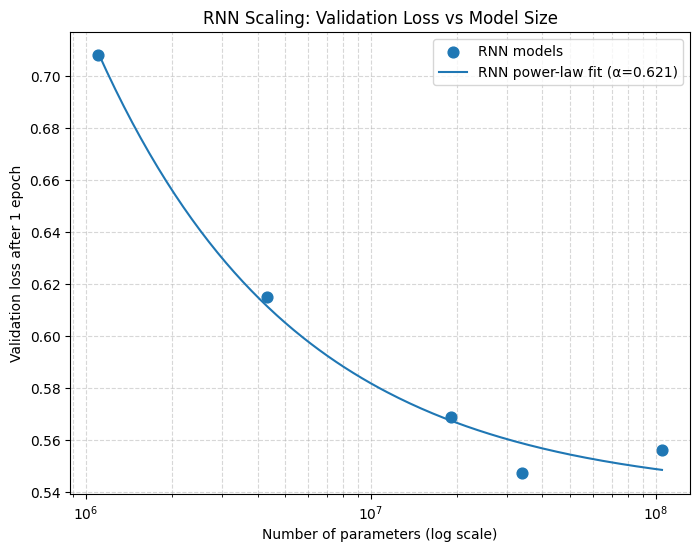

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Collect RNN stats from rnn_results list
N_rnn = np.array([r["n_params"] for r in rnn_results], dtype=np.float64)
L_rnn = np.array([r["val_loss"]  for r in rnn_results], dtype=np.float64)

print("RNN params:", N_rnn)
print("RNN val losses:", L_rnn)

def power_law(N, a, alpha, c):
    return a * N**(-alpha) + c

# Initial guesses
p0 = [1.0, 0.1, float(L_rnn.min() - 0.02)]
popt_rnn, pcov_rnn = curve_fit(power_law, N_rnn, L_rnn, p0=p0, maxfev=20000)

a_rnn, alpha_rnn, c_rnn = popt_rnn
print(f"RNN power law: L = a * N^(-alpha) + c")
print(f"a = {a_rnn:.4g}, alpha = {alpha_rnn:.4f}, c = {c_rnn:.4f}")

# Smooth curve for plotting
N_fit_rnn = np.logspace(np.log10(N_rnn.min()), np.log10(N_rnn.max()), 200)
L_fit_rnn = power_law(N_fit_rnn, a_rnn, alpha_rnn, c_rnn)

plt.figure(figsize=(8,6))
plt.scatter(N_rnn, L_rnn, s=60, label="RNN models")
plt.plot(N_fit_rnn, L_fit_rnn, label=f"RNN power-law fit (α={alpha_rnn:.3f})")

plt.xscale("log")
plt.xlabel("Number of parameters (log scale)")
plt.ylabel("Validation loss after 1 epoch")
plt.title("RNN Scaling: Validation Loss vs Model Size")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


# Combined Transformer vs RNN scaling plot

In [ ]:
import json
from pathlib import Path

results_dir = Path("/content/drive/MyDrive/music-project-ml-results")

# Reload transformers
transformer_names = ["tiny", "small", "medium", "large", "xl"]
results = []
for name in transformer_names:
    with open(results_dir / f"{name}_summary.json", "r") as f:
        results.append(json.load(f))

# Reload RNNs
rnn_names = ["rnn_tiny", "rnn_small", "rnn_medium", "rnn_large", "rnn_xl"]
rnn_results = []
for name in rnn_names:
    with open(results_dir / f"{name}_summary.json", "r") as f:
        rnn_results.append(json.load(f))


Transformer α ≈ 0.6715
RNN α ≈ 0.6214


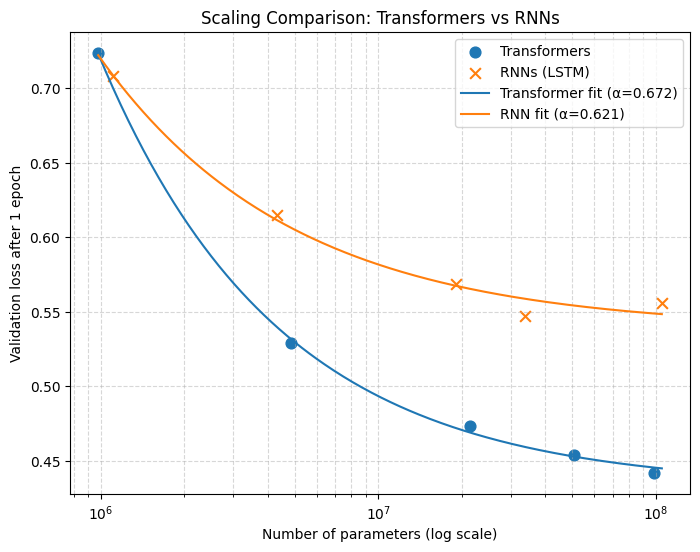

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def power_law(N, a, alpha, c):
    return a * N**(-alpha) + c

# Transformers
N_tf = np.array([r["n_params"] for r in results], dtype=np.float64)
L_tf = np.array([r["val_loss"]  for r in results], dtype=np.float64)

p0_tf = [1.0, 0.1, float(L_tf.min() - 0.05)]
popt_tf, _ = curve_fit(power_law, N_tf, L_tf, p0=p0_tf, maxfev=20000)
a_tf, alpha_tf, c_tf = popt_tf

# RNNs
N_rnn = np.array([r["n_params"] for r in rnn_results], dtype=np.float64)
L_rnn = np.array([r["val_loss"]  for r in rnn_results], dtype=np.float64)

p0_rnn = [1.0, 0.1, float(L_rnn.min() - 0.02)]
popt_rnn, _ = curve_fit(power_law, N_rnn, L_rnn, p0=p0_rnn, maxfev=20000)
a_rnn, alpha_rnn, c_rnn = popt_rnn

print(f"Transformer α ≈ {alpha_tf:.4f}")
print(f"RNN α ≈ {alpha_rnn:.4f}")

# Curves for nice visualization
N_fit = np.logspace(
    np.log10(min(N_tf.min(), N_rnn.min())),
    np.log10(max(N_tf.max(), N_rnn.max())),
    300
)
L_fit_tf  = power_law(N_fit, a_tf,  alpha_tf,  c_tf)
L_fit_rnn = power_law(N_fit, a_rnn, alpha_rnn, c_rnn)

plt.figure(figsize=(8,6))
plt.scatter(N_tf,  L_tf,  s=60, label="Transformers")
plt.scatter(N_rnn, L_rnn, s=60, label="RNNs (LSTM)", marker="x")

plt.plot(N_fit, L_fit_tf,  label=f"Transformer fit (α={alpha_tf:.3f})")
plt.plot(N_fit, L_fit_rnn, label=f"RNN fit (α={alpha_rnn:.3f})")

plt.xscale("log")
plt.xlabel("Number of parameters (log scale)")
plt.ylabel("Validation loss after 1 epoch")
plt.title("Scaling Comparison: Transformers vs RNNs")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


# Part 4: Best Model Training and Sample Generation

In [ ]:
import torch, math, time
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# --- Make sure test loader exists ---
test_ids = np.load("/content/drive/MyDrive/music-project-ml-tokenized/test_ids.npy")
test_dataset = TokenDataset(test_ids, block_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

def evaluate_loss_full(model, loader):
    """Average loss over the whole loader (for val/test)."""
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            _, loss = model(xb, yb)
            losses.append(loss.item())
    return sum(losses) / len(losses)

best_cfg = dict(n_layer=20, n_head=8, n_embd=640)

def build_best_model():
    config = GPTConfig(
        vocab_size=vocab_size,
        block_size=block_size,
        n_layer=best_cfg["n_layer"],
        n_head=best_cfg["n_head"],
        n_embd=best_cfg["n_embd"],
        dropout=0.1,
    )
    model = GPTModel(config).to(device)
    print("Best model params:", count_parameters(model))
    return model

def train_best_model_xl_train_only(
    epochs=1,
    base_lr=3e-4,
    local_save_path="best_xl_weights.pt",
    drive_save_path="/content/drive/MyDrive/music-project-ml-results/best_xl_weights.pt",
):
    model = build_best_model()
    optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=0.1)

    total_steps = epochs * steps_per_epoch
    warmup_steps = max(10, int(0.05 * total_steps))

    def get_lr(step):
        if step < warmup_steps:
            return base_lr * step / warmup_steps
        progress = (step - warmup_steps) / max(1, (total_steps - warmup_steps))
        return base_lr * 0.5 * (1.0 + math.cos(math.pi * progress))

    global_step = 0
    train_losses = []

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    start_time = time.time()

    for epoch in range(1, epochs + 1):
        print(f"\n=== Epoch {epoch}/{epochs} ===")
        model.train()
        train_iter = iter(train_loader)

        for step in range(1, steps_per_epoch + 1):
            global_step += 1
            try:
                xb, yb = next(train_iter)
            except StopIteration:
                train_iter = iter(train_loader)
                xb, yb = next(train_iter)

            xb, yb = xb.to(device), yb.to(device)

            lr_step = get_lr(global_step)
            for g in optimizer.param_groups:
                g["lr"] = lr_step

            optimizer.zero_grad(set_to_none=True)
            _, loss = model(xb, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_losses.append(loss.item())
            if step % 200 == 0 or step == 1:
                print(
                    f"epoch {epoch}/{epochs}, step {step}/{steps_per_epoch} "
                    f"- loss {loss.item():.4f} - lr {lr_step:.2e}"
                )

    total_time = time.time() - start_time
    peak_mem_gb = None
    if torch.cuda.is_available():
        peak_mem_gb = torch.cuda.max_memory_allocated() / 1e9

    
    torch.save(
        {
            "config": best_cfg,
            "model_state_dict": model.state_dict(),
            "train_losses": train_losses,
        },
        local_save_path,
    )
    print(f"\nSaved local weights to: {local_save_path}")


    try:
        !cp "$local_save_path" "$drive_save_path"
        print(f"Copied weights to Drive: {drive_save_path}")
    except Exception as e:
        print("Drive copy failed, but local file is safe:", e)

    print(f"\nFinished training best XL model (train-only).")
    print(f"Time: {total_time/60:.1f} min, Peak GPU mem: {peak_mem_gb:.2f} GB")

    return {
        "total_time_sec": total_time,
        "peak_mem_gb": peak_mem_gb,
        "drive_save_path": drive_save_path,
        "local_save_path": local_save_path,
    }


Device: cuda


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader

# load train_ids again
train_ids = np.load("/content/drive/MyDrive/music-project-ml-tokenized/train_ids.npy")

block_size = 256
batch_size = 64
tokens_per_batch = batch_size * block_size
steps_per_epoch = len(train_ids) // tokens_per_batch

print("Steps per epoch:", steps_per_epoch)


Steps per epoch: 6103


In [ ]:

best_train_only = train_best_model_xl_train_only(
    epochs=1,
    base_lr=3e-4,
    local_save_path="best_xl_weights.pt",
    drive_save_path="/content/drive/MyDrive/music-project-ml-results/best_xl_weights.pt",
)
best_train_only


Best model params: 98763520

=== Epoch 1/1 ===
epoch 1/1, step 1/6103 - loss 4.7494 - lr 9.84e-07
epoch 1/1, step 200/6103 - loss 1.3452 - lr 1.97e-04
epoch 1/1, step 400/6103 - loss 1.0143 - lr 3.00e-04
epoch 1/1, step 600/6103 - loss 0.7564 - lr 2.98e-04
epoch 1/1, step 800/6103 - loss 0.7064 - lr 2.95e-04
epoch 1/1, step 1000/6103 - loss 0.6041 - lr 2.89e-04
epoch 1/1, step 1200/6103 - loss 0.5921 - lr 2.83e-04
epoch 1/1, step 1400/6103 - loss 0.5932 - lr 2.74e-04
epoch 1/1, step 1600/6103 - loss 0.5877 - lr 2.65e-04
epoch 1/1, step 1800/6103 - loss 0.6015 - lr 2.53e-04
epoch 1/1, step 2000/6103 - loss 0.5492 - lr 2.41e-04
epoch 1/1, step 2200/6103 - loss 0.5177 - lr 2.28e-04
epoch 1/1, step 2400/6103 - loss 0.4917 - lr 2.13e-04
epoch 1/1, step 2600/6103 - loss 0.4895 - lr 1.98e-04
epoch 1/1, step 2800/6103 - loss 0.5197 - lr 1.83e-04
epoch 1/1, step 3000/6103 - loss 0.4882 - lr 1.67e-04
epoch 1/1, step 3200/6103 - loss 0.4679 - lr 1.50e-04
epoch 1/1, step 3400/6103 - loss 0.4426 - 

{'total_time_sec': 4168.170291662216,
 'peak_mem_gb': 21.47745536,
 'drive_save_path': '/content/drive/MyDrive/music-project-ml-results/best_xl_weights.pt',
 'local_save_path': 'best_xl_weights.pt'}

In [ ]:
import math
import numpy as np
import torch
from torch.utils.data import DataLoader

# =========================
# 0. Device
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# =========================
# 1. Eval dataset (non-overlapping)
# =========================
class EvalDataset(torch.utils.data.Dataset):
    """
    Evaluation dataset that uses non-overlapping chunks of length block_size.

    For N tokens, we create floor(N / block_size) sequences:
    x[i] = ids[i*block_size : (i+1)*block_size]
    y[i] = x shifted by one position (next-token prediction).
    """
    def __init__(self, ids, block_size):
        self.block_size = block_size
        ids = ids.astype(np.int64)
        total = len(ids) // block_size  # number of full blocks
        self.data = ids[: total * block_size].reshape(total, block_size)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        # next-token prediction within each block
        y = np.roll(x, -1)
        return (
            torch.tensor(x, dtype=torch.long),
            torch.tensor(y, dtype=torch.long),
        )

# =========================
# 2. Load checkpoint (local)
# =========================
ckpt_path = "best_xl_weights.pt"  # local file from training
checkpoint = torch.load(ckpt_path, map_location=device)
cfg = checkpoint["config"]

print("Loaded checkpoint from:", ckpt_path)
print("Config:", cfg)

# =========================
# 3. Rebuild model and load weights
# =========================
config = GPTConfig(
    vocab_size=vocab_size,
    block_size=block_size,
    n_layer=cfg["n_layer"],
    n_head=cfg["n_head"],
    n_embd=cfg["n_embd"],
    dropout=0.0,  # no dropout at eval
)
model = GPTModel(config).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model rebuilt and set to eval().")

# =========================
# 4. Build val/test loaders (small batch size)
# =========================
eval_batch_size = 4  # small batch to keep memory + time under control

def make_eval_loader(path):
    ids = np.load(path)
    ds = EvalDataset(ids, block_size)
    return DataLoader(ds, batch_size=eval_batch_size, shuffle=False, drop_last=False)

val_path = "/content/drive/MyDrive/music-project-ml-tokenized/val_ids.npy"
test_path = "/content/drive/MyDrive/music-project-ml-tokenized/test_ids.npy"

val_loader = make_eval_loader(val_path)
test_loader = make_eval_loader(test_path)

print("Val batches:", len(val_loader), "| Test batches:", len(test_loader))

# =========================
# 5. Evaluation helper
# =========================
def evaluate_loss_full(model, loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            _, loss = model(xb, yb)
            losses.append(loss.item())
    return sum(losses) / len(losses)

# =========================
# 6. Run eval on val + test
# =========================
print("Evaluating on validation set...")
val_loss = evaluate_loss_full(model, val_loader)
val_ppl = math.exp(val_loss)
print(f"VAL loss: {val_loss:.4f}, perplexity: {val_ppl:.2f}")

print("Evaluating on test set...")
test_loss = evaluate_loss_full(model, test_loader)
test_ppl = math.exp(test_loss)
print(f"TEST loss: {test_loss:.4f}, perplexity: {test_ppl:.2f}")


Device: cuda
Loaded checkpoint from: best_xl_weights.pt
Config: {'n_layer': 20, 'n_head': 8, 'n_embd': 640}
Model rebuilt and set to eval().
Val batches: 24414 | Test batches: 24414
Evaluating on validation set...
VAL loss: 0.4870, perplexity: 1.63
Evaluating on test set...
TEST loss: 0.4922, perplexity: 1.64


In [ ]:
import json
import torch

results = {
    "model_name": "xl_transformer",
    "n_layer": 20,
    "n_head": 8,
    "n_embd": 640,
    "parameters": 98763520,  
    "val_loss": 0.4870,
    "val_perplexity": 1.63,
    "test_loss": 0.4922,
    "test_perplexity": 1.64,
}

save_json_path = "/content/drive/MyDrive/music-project-ml-results/best_xl_eval_metrics.json"

with open(save_json_path, "w") as f:
    json.dump(results, f, indent=4)

print("Saved evaluation metrics JSON to:", save_json_path)


Saved evaluation metrics JSON to: /content/drive/MyDrive/music-project-ml-results/best_xl_eval_metrics.json


In [ ]:
combined_ckpt_path = "/content/drive/MyDrive/music-project-ml-results/best_xl_full_checkpoint.pt"

torch.save(
    {
        "config": best_cfg,
        "weights": torch.load("best_xl_weights.pt")["model_state_dict"],
        "eval_results": results,
    },
    combined_ckpt_path,
)

print("Saved combined full checkpoint to:", combined_ckpt_path)


Saved combined full checkpoint to: /content/drive/MyDrive/music-project-ml-results/best_xl_full_checkpoint.pt
